In [41]:
import sys
import pandas as pd
import numpy as np

sys.path.append('/home/yuliya/repos/cosybio/FedProt/evaluation_utils/')
from evaluation import evaluation_func as fp_eval

from collections import OrderedDict

In [42]:
color_dict = OrderedDict()

color_dict["Methods"] = OrderedDict({
    "FedProt":"black",
    "Fisher":"#E69F00",
    "Stouffer":"#D44400",
    "REM":"#009E73",
    "RankProd":"#2E5EAA"
})

# Read results

In [43]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/"

dfs = {}

workdir = root_dir + "balanced/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Balanced"] = df

workdir = root_dir + "imbalanced/results"
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Imbalanced"] = df


print(dfs["Imbalanced"].shape)
dfs["Imbalanced"].head(4)

Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results with 2252 genes. Adj.p-values were not log-transformed.
Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/imbalanced/results with 2245 genes. Adj.p-values were not log-transformed.


(2245, 12)


,pv_DEqMS,lfc_DEqMS,pv_FedProt,lfc_FedProt,lfc_Fisher,pv_Fisher,lfc_REM,pv_REM,pv_Stouffer,lfc_Stouffer,pv_RankProd,lfc_RankProd
A5A614,5.770633e-14,-0.722935,5.770633e-14,-0.722935,-0.733563,7.781520e-14,-0.729038,4.880849e-07,2.951986e-12,-0.733563,0.031255,-0.733563
O32583,4.145078e-11,-0.800755,4.145078e-11,-0.800755,-0.826705,1.090867e-08,-0.718343,1.077950e-12,1.808742e-09,-0.826705,0.018847,-0.826705
P00350,2.725214e-11,0.218893,2.725214e-11,0.218893,0.207179,9.483586e-17,0.219851,1.589311e-18,4.665715e-13,0.207179,0.197081,0.207179
P00363,4.103906e-02,-0.121719,4.103906e-02,-0.121719,-0.114420,1.674393e-01,-0.125439,2.047669e-02,3.501879e-01,-0.114420,0.597490,-0.114420


# Deviations in the results of decentralized methods

First - for balanced.  
adj. p-val:
- min diff (supplementary)
- mean diff,
- max diff, 
- r, 
- rho

log2FC - same, for supplementary.
  




## stats tables

In [46]:
for dataset in dfs:
    pval_basic_stats = fp_eval.calc_stats(
        dfs[dataset], 
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ", "RMSE", "NRMSE"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="pv_",
        top_genes=-1
    )
    logfc_basic_stats = fp_eval.calc_stats(
        dfs[dataset],
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ", "RMSE", "NRMSE"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="lfc_",
        top_genes=-1
    )

    # save to file, dataset to lower case
    dataset = dataset.lower()
    pval_basic_stats.to_csv(f'{root_dir}/{dataset}/results_tables/pval_basic_stats.csv')
    logfc_basic_stats.to_csv(f'{root_dir}/{dataset}/results_tables/logfc_basic_stats.csv')

    print(f'Dataset: {dataset}')
    # print("\tLogFC basic stats:")
    # print(logfc_basic_stats)
    print("\tP-value basic stats:")
    print(pval_basic_stats)        

Calculating RMSE. Using p-vals - not log-transformed.
RMSE and NRMSE computed for all genes from pv_ columns.
Calculating corrs. Using p-vals - not log-transformed.
Correlations computed for all genes from pv_ columns.
RMSE and NRMSE computed for all genes from lfc_ columns.
Correlations computed for all genes from lfc_ columns.
Calculating RMSE. Using p-vals - not log-transformed.
RMSE and NRMSE computed for all genes from pv_ columns.
Calculating corrs. Using p-vals - not log-transformed.
Correlations computed for all genes from pv_ columns.
RMSE and NRMSE computed for all genes from lfc_ columns.
Correlations computed for all genes from lfc_ columns.


Dataset: balanced
	P-value basic stats:
                MinDiff      MeanDiff       MaxDiff         r         ρ  \
FedProt    0.000000e+00  2.954192e-14  1.330158e-12  1.000000  1.000000   
Fisher    3.887121e-108  5.818456e-02  9.999922e-01  0.356563  0.956543   
Stouffer  3.887121e-108  5.973242e-02  9.999877e-01  0.389234  0.964917   
REM       3.887121e-108  5.439899e-02  7.138192e-01  0.834965  0.905285   
RankProd   5.142533e-15  2.097048e-01  6.938618e-01  0.505077  0.875888   

                  RMSE         NRMSE  
FedProt   1.016524e-13  3.000945e-12  
Fisher    1.795556e-01  5.300773e+00  
Stouffer  1.793391e-01  5.294381e+00  
REM       1.289957e-01  3.808162e+00  
RankProd  2.842665e-01  8.392008e+00  
Dataset: imbalanced
	P-value basic stats:
               MinDiff      MeanDiff       MaxDiff         r         ρ  \
FedProt   0.000000e+00  2.540051e-14  1.172173e-12  1.000000  1.000000   
Fisher    4.627069e-70  6.777583e-02  9.939051e-01  0.413304  0.945877   
Stouffer  4

In [33]:
for dataset in dfs:
    transfomed_dataset = dfs[dataset].copy()
    
    # transform p-values to -log10 pv_ + column["FedProt", "Fisher", "Stouffer", "REM", "RankProd"]
    # there is no function in the evaluation_utils for this, so we will do it manually
    for method in ["DEqMS", "FedProt", "Fisher", "Stouffer", "REM", "RankProd"]:
        # first replace zeros with smallest non-zero value (offset)
        offset = transfomed_dataset[f"pv_{method}"].replace(0, np.nan).min()
        transfomed_dataset[f"pv_{method}"] = transfomed_dataset[f"pv_{method}"].replace(0, offset)        
        transfomed_dataset[f"pv_{method}"] = -np.log10(transfomed_dataset[f"pv_{method}"])

    pval_basic_stats = fp_eval.calc_stats(
        transfomed_dataset, 
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MeanDiff", "MaxDiff", "r", "ρ", "RMSE", "NRMSE"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="pv_",
        top_genes=-1
    )
    # save to file, dataset to lower case
    dataset = dataset.lower()
    pval_basic_stats.to_csv(f'{root_dir}/{dataset}/results_tables/log10pval_basic_stats.csv')
    
    print(f'Dataset: {dataset}')
    print("\tP-value basic stats:")
    print(pval_basic_stats)        

Calculating RMSE. Using p-vals - log-transformed.


RMSE and NRMSE computed for all genes from pv_ columns.
Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
Calculating RMSE. Using p-vals - log-transformed.
RMSE and NRMSE computed for all genes from pv_ columns.
Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.


Dataset: balanced
	P-value basic stats:
              MeanDiff       MaxDiff         r         ρ          RMSE  \
FedProt   6.727534e-13  4.931167e-12  1.000000  1.000000  9.414345e-13   
Fisher    4.793878e+00  3.131435e+01  0.980620  0.956843  6.497936e+00   
Stouffer  3.998185e+00  2.699362e+01  0.988331  0.965187  5.626049e+00   
REM       1.659226e+01  2.578517e+02  0.764905  0.905286  4.127313e+01   
RankProd  1.668376e+01  1.006374e+02  0.771430  0.876273  2.501213e+01   

                 NRMSE  
FedProt   2.400579e-15  
Fisher    1.656919e-02  
Stouffer  1.434595e-02  
REM       1.052430e-01  
RankProd  6.377883e-02  
Dataset: imbalanced
	P-value basic stats:
              MeanDiff       MaxDiff         r         ρ          RMSE  \
FedProt   4.268203e-13  4.192202e-12  1.000000  1.000000  6.228942e-13   
Fisher    3.536972e+00  2.154460e+01  0.974878  0.945978  4.835147e+00   
Stouffer  2.582266e+00  2.094675e+01  0.983923  0.951580  3.747985e+00   
REM       1.442783e+01  2.6

### correlation plots

Plotting corrs using p-vals - log-transformed.


Balanced                         Imbalanced                        
                 r         ρ          RMSE          r         ρ          RMSE
FedProt   1.000000  1.000000  9.412256e-13   1.000000  1.000000  6.227555e-13
Fisher    0.980614  0.956601  6.498508e+00   0.974887  0.945949  4.834297e+00
Stouffer  0.988327  0.964964  5.625929e+00   0.983927  0.951537  3.747290e+00
REM       0.763494  0.905410  4.170858e+01   0.749587  0.897226  4.026268e+01
RankProd  0.771453  0.876050  2.500658e+01   0.770441  0.864332  1.594350e+01

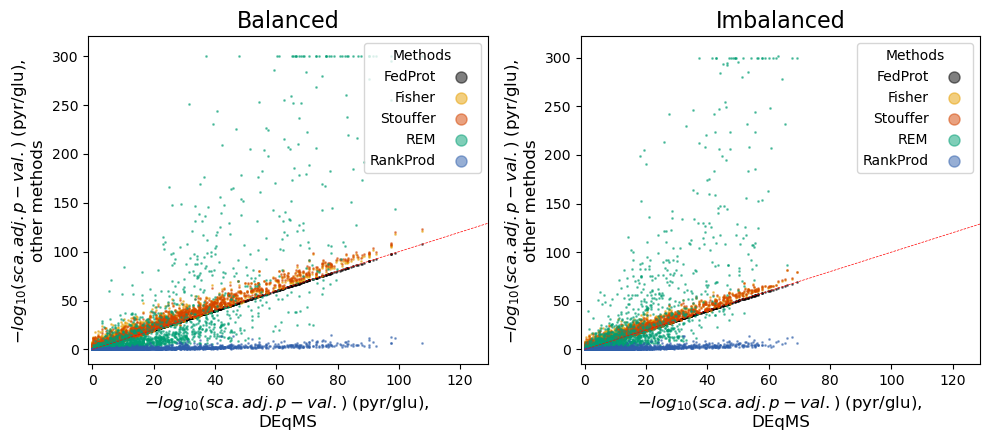

In [47]:
# log transform p-values in dfs, but first replace 0 with tiny value
log_dfs = {}
for k in dfs:
    df = dfs[k]
    df = df.replace(0,1e-300)
    df["pv_DEqMS"] = -np.log10(df["pv_DEqMS"])
    for m in ["FedProt", "Fisher","Stouffer","REM","RankProd"]:
        df["pv_"+m] = -np.log10(df["pv_"+m])
    log_dfs[k] = df

fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="pv_", 
    text="", dotsize=1,
    datasets=["Balanced", "Imbalanced"],
    add_table=False
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

Plotting corrs using p-vals - log-transformed.


Balanced                         Imbalanced                        
                 r         ρ          RMSE          r         ρ          RMSE
FedProt   1.000000  1.000000  9.412256e-13   1.000000  1.000000  6.227555e-13
Fisher    0.980614  0.956601  6.498508e+00   0.974887  0.945949  4.834297e+00
Stouffer  0.988327  0.964964  5.625929e+00   0.983927  0.951537  3.747290e+00
REM       0.763494  0.905410  4.170858e+01   0.749587  0.897226  4.026268e+01
RankProd  0.771453  0.876050  2.500658e+01   0.770441  0.864332  1.594350e+01

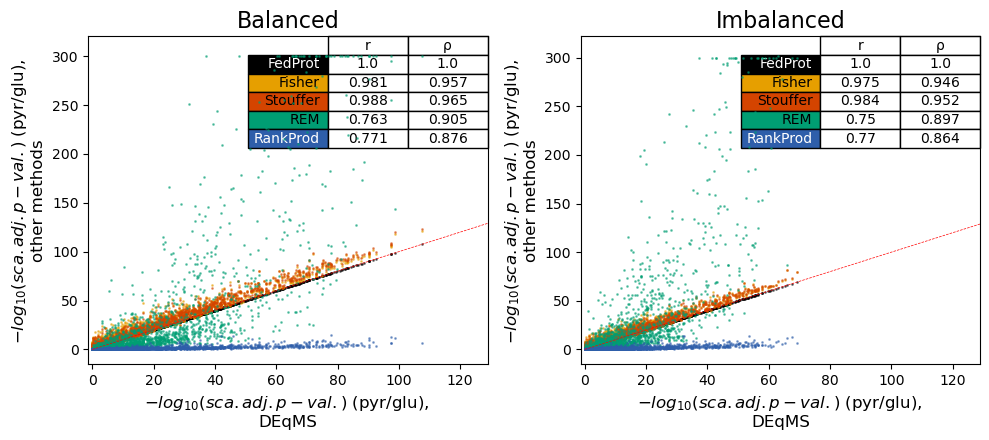

In [48]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="pv_", 
    text="", dotsize=1,
    datasets=["Balanced", "Imbalanced"],
    add_table=True
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

Plotting corrs using p-vals - log-transformed.


Balanced                         Imbalanced                        
                 r         ρ          RMSE          r         ρ          RMSE
FedProt   1.000000  1.000000  9.412256e-13   1.000000  1.000000  6.227555e-13
Fisher    0.980614  0.956601  6.498508e+00   0.974887  0.945949  4.834297e+00
Stouffer  0.988327  0.964964  5.625929e+00   0.983927  0.951537  3.747290e+00
REM       0.763494  0.905410  4.170858e+01   0.749587  0.897226  4.026268e+01
RankProd  0.771453  0.876050  2.500658e+01   0.770441  0.864332  1.594350e+01

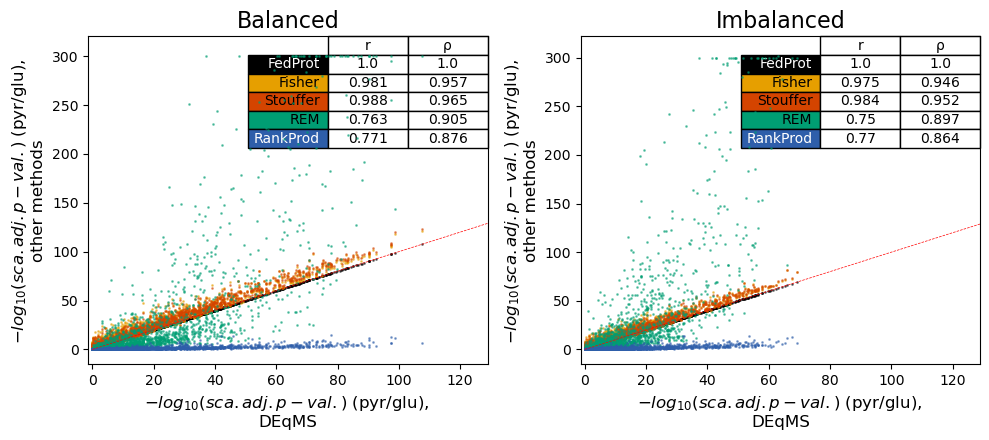

In [36]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="pv_", 
    text="", dotsize=1,
    datasets=["Balanced", "Imbalanced"],
    add_table=True
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

Plotting corrs using logFC values.


Balanced                         Imbalanced                        
                 r         ρ          RMSE          r         ρ          RMSE
FedProt   1.000000  1.000000  1.563650e-14   1.000000  1.000000  1.541568e-14
Fisher    0.999643  0.999833  1.857062e-02   0.998207  0.997623  4.253941e-02
Stouffer  0.999643  0.999833  1.857062e-02   0.998207  0.997623  4.253941e-02
REM       0.999330  0.998282  2.537571e-02   0.997985  0.996304  4.368611e-02
RankProd  0.999643  0.999833  1.857062e-02   0.998207  0.997623  4.253941e-02

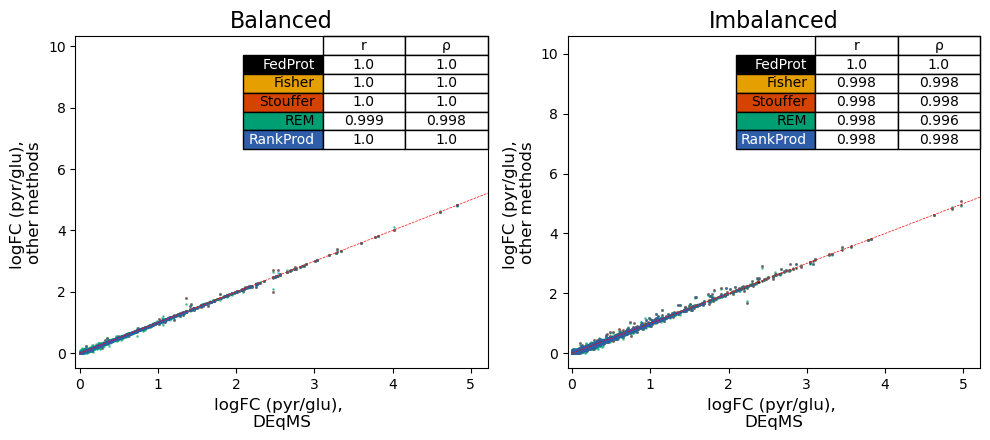

In [37]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="lfc_", 
    text="", dotsize=1,
    datasets=["Balanced", "Imbalanced"],
    add_table=True
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

# The consistency of differentially expressed protein lists


In [38]:
# calculate FP, FN and F1

for dataset in dfs:
    pval_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset], 
        lfc_thr=0.6, adj_pval_thr=0.01,
        stats=["FP", "FN", "F1"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="pv_",
        top_genes=-1
    )
    print(f'Dataset: {dataset}')
    print("\tFP, FN and F1:")
    print(pval_basic_stats)

    dataset = dataset.lower()
    pval_basic_stats.to_csv(f'{root_dir}/{dataset}/results_tables/fp_fn_f1.csv')

Performance metrics calculated for all genes.


Performance metrics calculated for all genes.


Dataset: Balanced
	FP, FN and F1:
           FP     FN        F1
FedProt   0.0    0.0  1.000000
Fisher    4.0    2.0  0.993711
Stouffer  4.0    2.0  0.993711
REM       5.0   13.0  0.980932
RankProd  2.0  126.0  0.845411
Dataset: Imbalanced
	FP, FN and F1:
            FP     FN        F1
FedProt    0.0    0.0  1.000000
Fisher    19.0   12.0  0.967126
Stouffer  19.0   12.0  0.967126
REM        8.0   24.0  0.965217
RankProd   3.0  130.0  0.835600


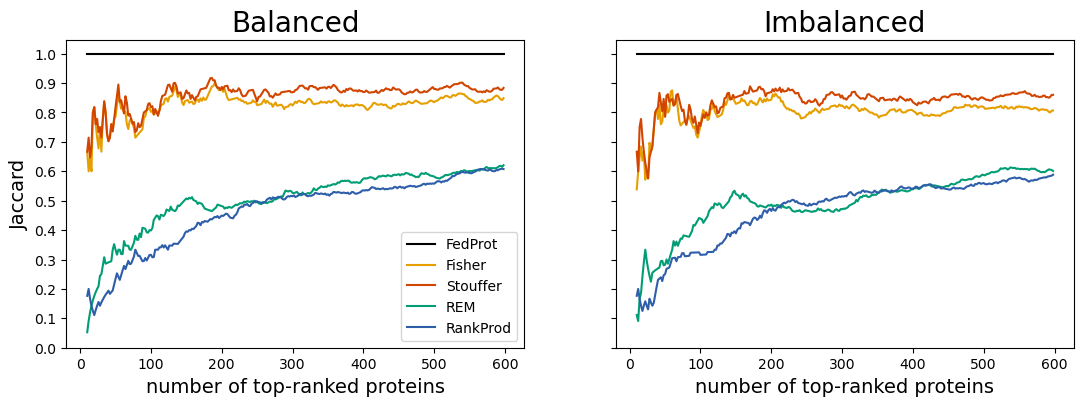

In [39]:
min_n_genes = 10
step = 2
max_n_genes = 600

data = fp_eval.plot_stats_for_topN(
    log_dfs,
    datasets = ["Balanced", "Imbalanced"],
    methods=["FedProt", "Fisher","Stouffer","REM","RankProd"],
    metrics=["Jaccard"],
    min_n_genes=min_n_genes,
    max_n_genes=max_n_genes,
    step=step,
    color_dict=color_dict,
    sharey=True
    )

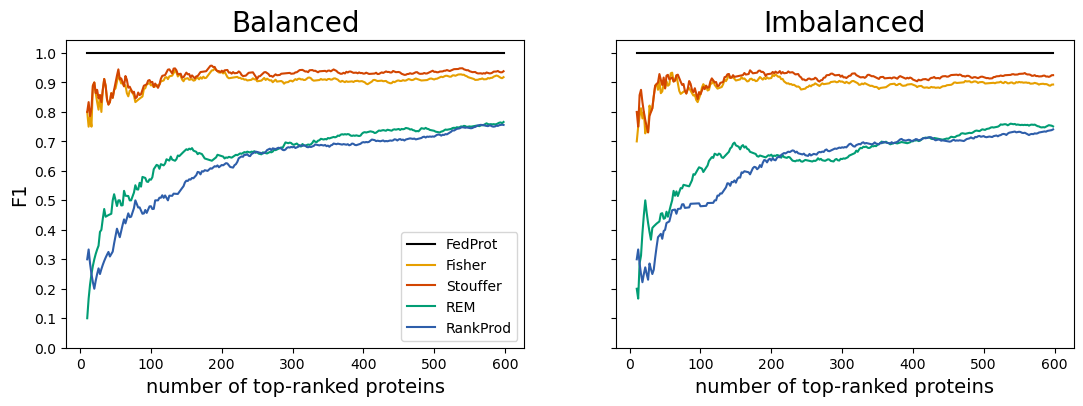

In [40]:
min_n_genes = 10
step = 2
max_n_genes = 600

data = fp_eval.plot_stats_for_topN(
    log_dfs,
    datasets = ["Balanced", "Imbalanced"],
    methods=["FedProt", "Fisher","Stouffer","REM","RankProd"],
    metrics=["F1"],
    min_n_genes=min_n_genes,
    max_n_genes=max_n_genes,
    step=step,
    color_dict=color_dict,
    sharey=True
    )